<a href="https://colab.research.google.com/github/srinath2022/physics-based-DL/blob/master/toyexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Toy Example

We will start off by considering a toy example of tossing a coin and eventually add air resistance etc. Let us begin by writing down the velocity and displacement equations of a point mass object thrown vertically above the ground with an initial velocity $u_0$.   

Under the effect of gravity, the velocity of the object at any time instant from start($t=0$) is given by   

$ v_t = u_0 + gt $   

where $g$ represents acceleration due to gravity $\sim 10 \frac{m}{s^2}$ 

Also, the displacement covered by the point mass is given by

$ s_t = u_0t + \frac{1}{2}gt^2 $

In [ ]:
import matplotlib.pyplot as plt

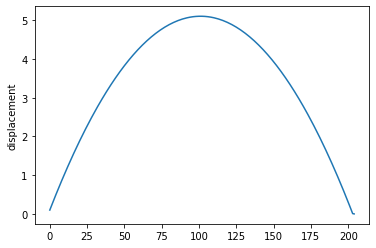

In [ ]:
## mks units 
u_int = 10
a = -9.8
throw_flag = False
dt = 0.01
t = 0
vert_disp = []
v = u_int + a* dt
ds = (v**2 - u_int**2)/(2*a)
s =ds
vert_disp.append(s)
u_int = v
while( s > 0):
  v = u_int + a* dt
  ds = (v**2 - u_int**2)/(2*a)
  s+= ds
  t = t + dt
  if(s <= 0):
    s = 0
  vert_disp.append(s)  
  u_int = v

# Plot the displacement
plt.plot(vert_disp)
plt.ylabel('displacement')
plt.show()

In [ ]:
# Commenting out as this is not use currently
# !pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop
# import numpy as np
# from phi.flow import *
# import torch